**Oreum Industries Internal Project, 2024Q1**

---

# 100_ModelA0.ipynb

### Oreum Copula Demo in `oreum_copula`

Implementation of Bayesian Copula-Based Expected Loss Cost Forecasting. 
We use highly advanced Bayesian inference techniques and a Bayesian workflow, 
specifically using the `pymc` & `arviz` ecosystem.

Here we demonstrate an E2E workflow for novel models of increasing sophistication.
We evaluate the behaviour and performance of the models throughout the workflows,
including several state-of-the-art methods unavailable to conventional
max-likelihood / machine-learning models.

**In this Notebook:**

+ Build & evaluate `ModelA0`, a naive version of the core project architecture **without a copula**
+ Demonstrate some of the core aspects and make the case for needing a copula


## Contents

+ [Setup](#Setup)

+ [0. Synthesize Dataset](#0.-Synthesize-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `ModelA0`](#2.-Custom-Bayesian-Model-`ModelA0`)

---

# Setup

## Imports

In [1]:
import sys
from copy import deepcopy
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns

# from IPython.display import Markdown, display
from oreum_core import eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))    # sys.path.append(str(module_path))

# autoreload local modules to allow local dev
%load_ext autoreload
%autoreload 2
from engine import logger, utils  #.trainer import Trainer
from model import copula
from synthetic.create_copula import CopulaBuilder

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip

/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='muted', context='notebook', 
        rc={'savefig.dpi':300, 'figure.figsize': (12, 3)})

log = logger.get_logger('000_Example_ModelA0', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RSD = 42
RNG = np.random.default_rng(seed=RSD)

## Data Connections and Helper Objects

In [4]:
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))

---

---

# 0. Load Dataset

## 0.1 Synthetise Demo Dataset for Project

See `000_MRE_EDA.ipynb` for details

In [5]:
cb = CopulaBuilder()
df_all = cb.create(nobs=60)
print(cb.ref_vals)

{'c_r': -0.7, 'c_cov': array([[ 1. , -0.7],
       [-0.7,  1. ]]), 'm0_kind': 'lognorm', 'm1_kind': 'lognorm', 'm0_params': {'mu': 0.2, 'sigma': 0.5}, 'm1_params': {'mu': 2.0, 'sigma': 1.0}}


In [6]:
perm = RNG.permutation(df_all.index.values)
df_train = df_all.loc[perm[:50]]
df_holdout = df_all.loc[perm[50:]]
# eda.describe(df_train, nobs=3, get_counts=False)
eda.display_ht(df_train)

,c0,c1,u0,u1,m0,m1,u0x,u1x,m0x,m1x
28,0.83,0.33,0.80,0.63,1.85,10.23,0.83,0.69,1.95,12.28
55,-0.31,0.49,0.38,0.69,1.05,12.09,0.99,0.78,4.11,16.25
18,-0.22,-0.43,0.41,0.33,1.09,4.80,0.49,0.78,1.20,15.85
0,-0.68,-0.12,0.25,0.45,0.87,6.54,0.08,0.52,0.61,7.75
47,1.00,-2.12,0.84,0.02,2.01,0.89,0.95,0.11,2.82,2.12
45,-0.65,0.58,0.26,0.72,0.88,13.14,0.81,0.56,1.89,8.49


'Shape: (50, 10), Memsize 0.0 MB'

## 0.2 Quick EDA to remind how the data looks

### 0.2.1 Jointplot marginals $M_{0}$, $M_{1}$

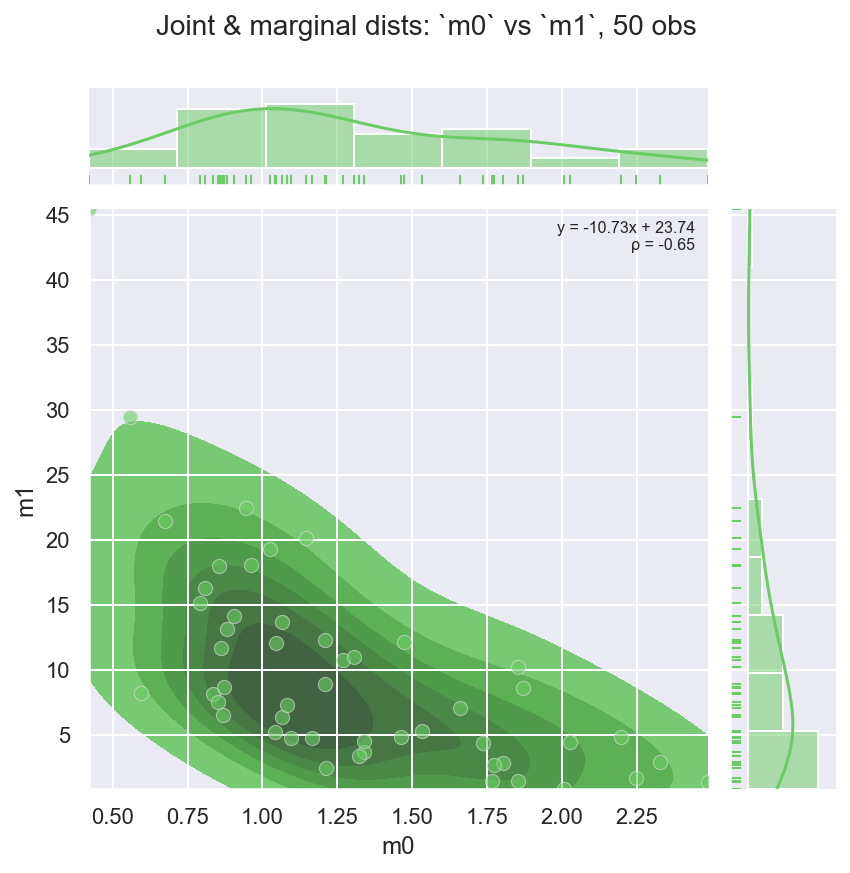

In [7]:
f = eda.plot_joint_numeric(data=df_train, ft0='m0', ft1='m1', kind='kde+scatter', colori=2, 
            subtitle='Observed Marginals with Copula Correlation')

**Observe:**

+ Note the negative correlation $\rho \approx -0.4$ and the skewed marginals with different scales

### 0.2.2 Plot product $y = M_{0} * M_{1}$ to motivate correct estimation of copula

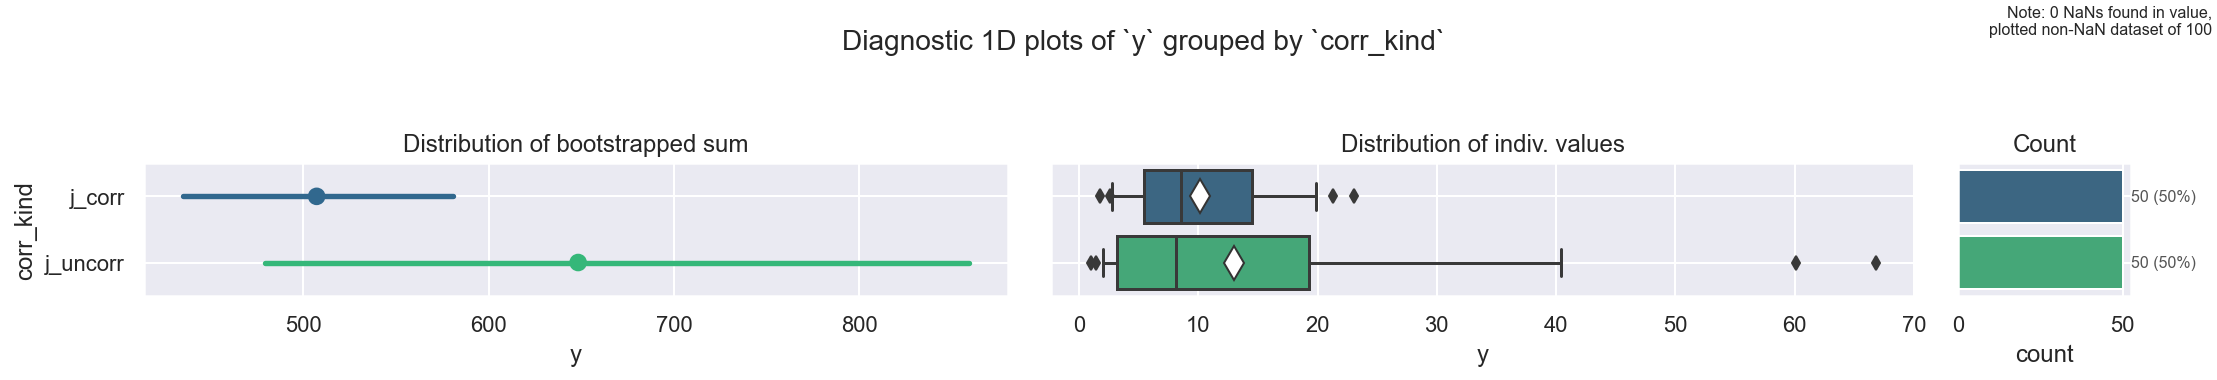

In [8]:
dfp = pd.concat((df_train[['m0', 'm1']], df_train[['m0x', 'm1x']]\
                 .rename(columns={'m0x':'m0', 'm1x': 'm1'})),
                axis=0, ignore_index=True)
dfp['corr_kind'] = np.repeat(['j_corr', 'j_uncorr'], repeats=len(df_train))
dfp['y'] = dfp[['m0', 'm1']].product(axis=1)
pal = sns.color_palette(['C2', 'C3'])
f = eda.plot_smrystat_grp(dfp, grp='corr_kind', val='y', palette=pal)

**Observe:**

+ The (bootstrapped) sum of `j_uncorr` ($\mu \approx 650$) is almost always much higher than for `j_corr` ($\mu \approx 500$)
+ This shows that even if we estimated each marginal correctly, if our model were to (erroroneously) ignore the coupled covariance between our marginals `m0`, `m1`, we would (erroneously) overestimate the joint distribution total value

---

---

# 1. Model Description

## 1.1 Estimate Marginals

In `ModelA0` we demonstrate a very naive way to estimate the marginals: as **independent distributions without a copula**.

Interestingly, because we sample the marginals simultaneously within a single model, this is still massively better than
estimating two completely separate models (one per marginal) as is often done in simple Frequentist modelling.

We have two marginals $M_{0}$ and $M_{1}$, which we estimate as both being $\text{LogNormal}$ distributions (because we
want to keep this example simple):

$$
\begin{aligned}
\beta_{M_{0}}^{j0} &\sim \text{Normal}(\mu, \sigma) \\
\sigma_{M_{0}} &\sim \text{InverseGamma}(\alpha, \beta) \\
\mathcal{L}\ \hat{M_{0}} &\sim \text{LogNormal}(\beta_{M_{0}}^{T}\mathbf{x}_{i}^{j0}, \sigma_{M_{0}}) \\
\\
\beta_{M_{1}}^{j1} &\sim \text{Normal}(\mu, \sigma) \\
\sigma_{M_{1}} &\sim \text{InverseGamma}(\alpha, \beta) \\
\mathcal{L}\ \hat{M_{1}} &\sim \text{LogNormal}(\beta_{M_{1}}^{T}\mathbf{x}_{i}^{j1}, \sigma_{M_{1}}) \\
\end{aligned}
$$

where:

+ We treat marginal $M_{0}$ and $M_{1}$ separately, although both are estimated as a $\text{LogNormal}$
+ Observations $\mathbf{x}_{i}$ have features $j$, and we define simple linear coefficients $\beta_{M_{0}}^{j0}$
+ Note in this example synthetic dataset we dont have any features, so we just set an intercept and retain the formality
  of the structure for general later usage
+ The linear sub-models e.g. $\beta_{M_{0}}^{T}\mathbf{x}^{j0}$ let us regress onto (potentially independent) subsets 
  of features $j0$ and $j1$


---

---

# 2. Custom Bayesian Model `ModelA0`

This is the first of many Bayesian models that we will create in this project. Refer to `000_Intro.ipynb` $\S \text{Preamble}$
for the myriad reasons this is a better general method to use.

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use the transformed datasets `dfx_*` 
in all subsequent models where possible.

NOTE:

+ For this example Notebook we _will_ partition into `train` & `holdout` sets
  (see `README.md ## 5. Data Standards` for terminology)
+ We will (as usual) evaluate in-sample using Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ We will also evaluate out-of-sample (because we have the ground truth) to demonstrate model behaviour
+ This means we still follow our standard process for preparation, transformation, standardization for `dfa` and `dfb`
+ Our model architecture wants two dataframes `obs_m0` and `obs_m1`, one per marginal - and we will make these based on arg `kind`
+ We have no features for `m0` and `m1`, so the linear sub-models have to be intercept-only. 
+ Here we must also forget anything we know about the construction of the synthetic data, this is all we have.

### Fit and transform `train` set

In [9]:
dfx_creator_m0 = utils.ProjectDFXCreator(kind='m0')
dfx_m0_train = dfx_creator_m0.get_dfx(df_train)
eda.describe(dfx_m0_train)

dfx_creator_m1 = utils.ProjectDFXCreator(kind='m1')
dfx_m1_train = dfx_creator_m1.get_dfx(df_train)
eda.describe(dfx_m1_train)

,32,4,37,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,16.00,7.00,46.00,int64,0,0,1,1550.00,31.00,16.89,0.00,18.25,30.50,45.75,59.00
m0,1.32,0.83,1.46,float64,0,0,0,64.71,1.29,0.50,0.42,0.89,1.19,1.72,2.49
intercept,1.00,1.00,1.00,float64,0,0,0,50.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (50, 3), Memsize 0.0 MB'

,4,34,41,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,7.00,34.00,11.00,int64,0,0,1,1550.0,31.00,16.89,0.00,18.25,30.50,45.75,59.00
m1,8.15,15.13,21.48,float64,0,0,0,493.0,9.86,8.25,0.89,4.47,7.84,12.93,45.47
intercept,1.00,1.00,1.00,float64,0,0,0,50.0,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (50, 3), Memsize 0.0 MB'

### Transform `holdout` set

In [10]:
dfx_m0_holdout = dfx_creator_m0.get_dfx(df_holdout, in_sample=False)
eda.describe(dfx_m0_holdout)

dfx_m1_holdout = dfx_creator_m1.get_dfx(df_holdout, in_sample=False)
eda.describe(dfx_m1_holdout)

,4,8,7,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,2.00,13.00,1.00,int64,0,0,0,220.00,22.00,19.25,1.00,9.00,13.50,35.25,58.00
m0,2.33,1.03,1.04,float64,0,0,0,13.73,1.37,0.48,0.86,1.05,1.21,1.49,2.33
intercept,1.00,1.00,1.00,float64,0,0,0,10.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (10, 3), Memsize 0.0 MB'

,4,6,1,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,2.00,33.00,43.00,int64,0,0,0,220.00,22.00,19.25,1.00,9.00,13.50,35.25,58.00
m1,0.74,4.48,4.82,float64,0,0,0,82.54,8.25,6.15,0.74,4.38,5.99,11.89,21.25
intercept,1.00,1.00,1.00,float64,0,0,0,10.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (10, 3), Memsize 0.0 MB'

## 2.1 Build Model Object

`ModelA0` model imported from `src.model.model_a.py` where it is fully defined

In [11]:
mdla0 = copula.ModelA0(obs_m0=dfx_m0_train, obs_m1=dfx_m1_train, 
            ft_en_m0=dfx_creator_m0.ft_en, ft_en_m1=dfx_creator_m1.ft_en, 
            factor_map_m0=dfx_creator_m0.factor_map, factor_map_m1=dfx_creator_m1.factor_map,
            obs_nm='dfx_train')
mdla0.build()
utils.display_rvs(mdla0)
mdla0.debug()


'RVs for mdla0, v1.2.0, dfx_train'

beta_m0 ~ Normal(0, 1)

beta_m1 ~ Normal(0, 1)

sigma ~ InverseGamma(5, 4)

yhat ~ Deterministic(f(mhat))

point={'beta_m0': array([0.]), 'beta_m1': array([0.]), 'sigma_log__': array([0., 0.])}

No problems found
point={'beta_m0': array([0.]), 'beta_m1': array([0.]), 'sigma_log__': array([0., 0.])}

No problems found


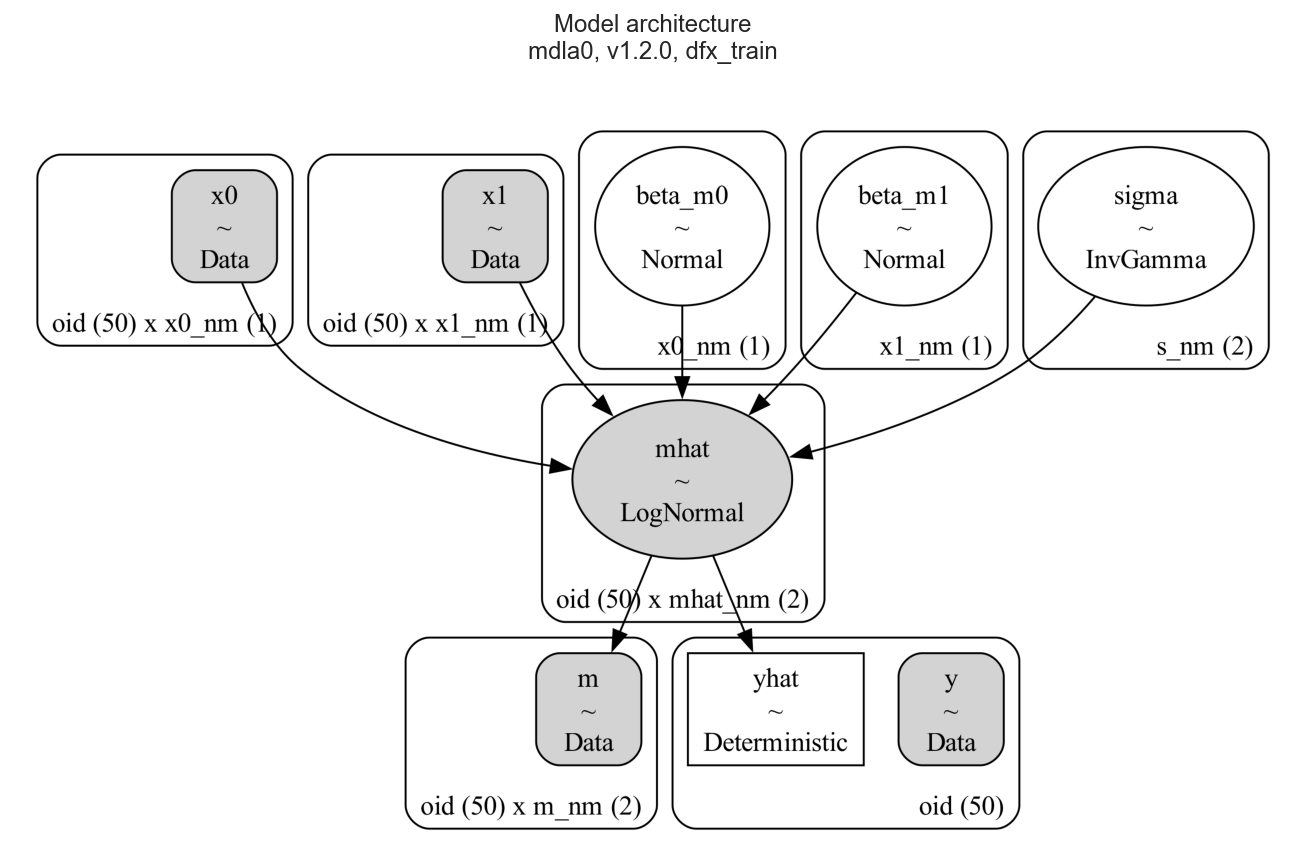

In [12]:
fqn = mdlio.write_graph(mdla0)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdla0.mdl_id}', figsize=(12, 6))

## 2.2 Sample Prior Predictive, View Diagnostics

In [13]:
mdla0.sample_prior_predictive(var_names=mdla0.rvs_marg + mdla0.rvs_ppc, replace=True)

#### Evaluate Prior PPC

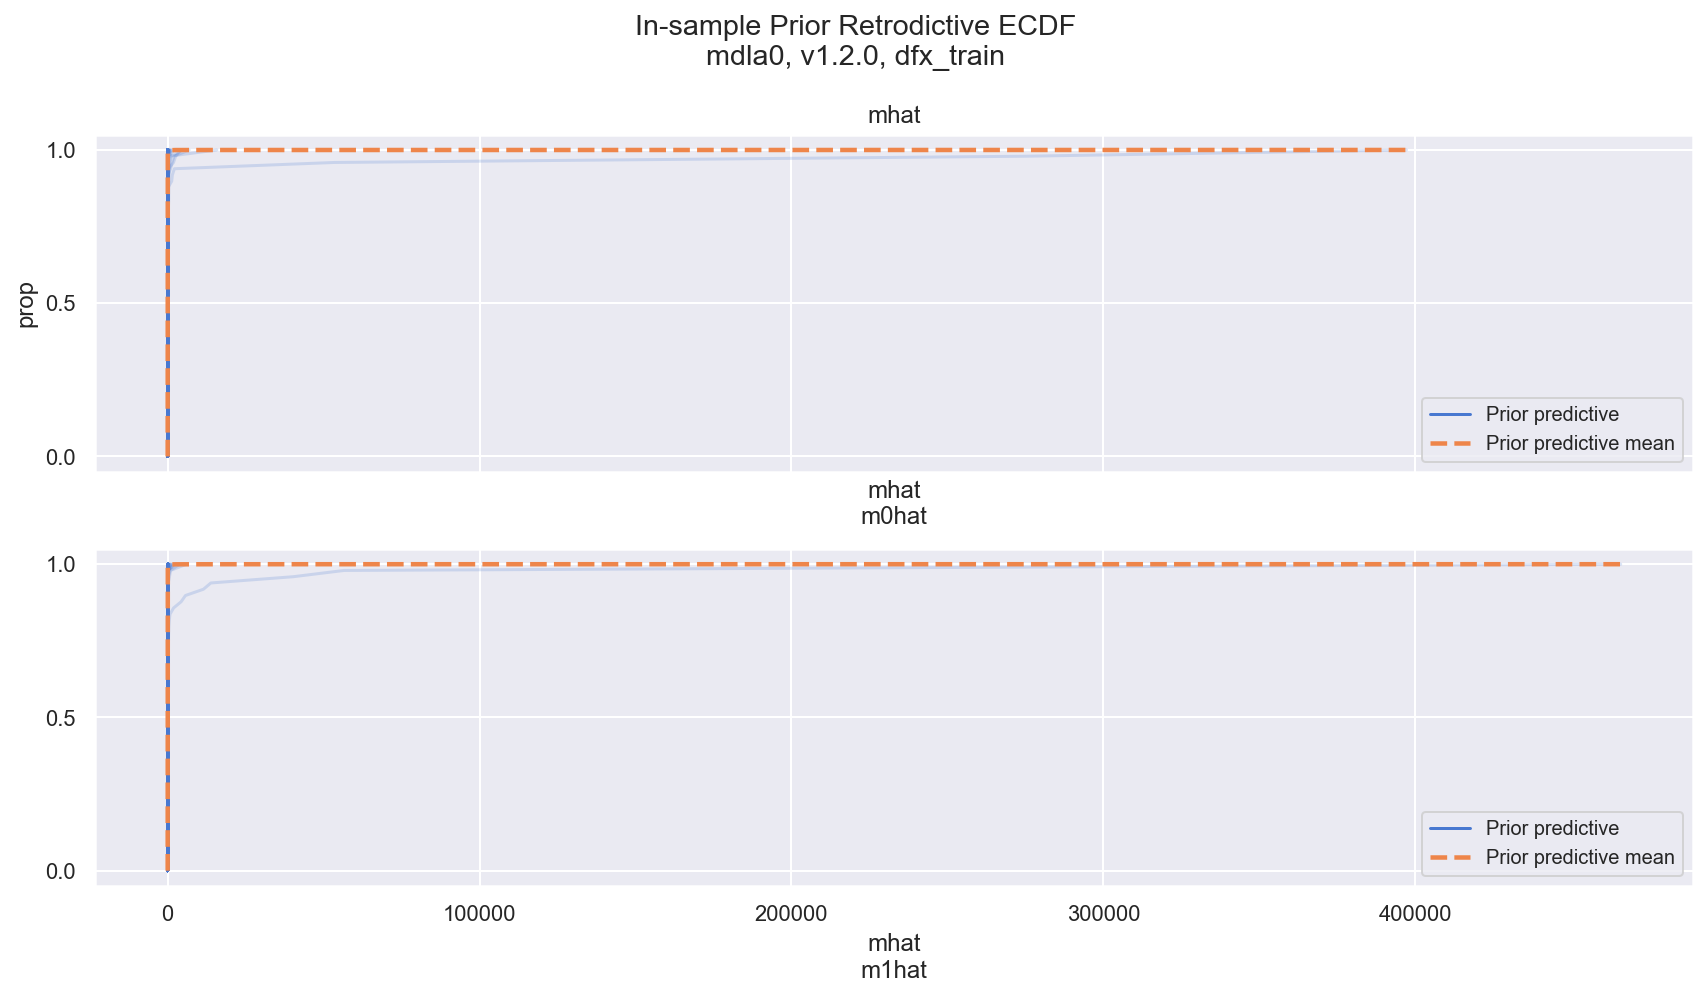

In [14]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=mdla0.rvs_ppc, flatten=['oid'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is valid

#### Evaluate priors and hyperpriors on linear model

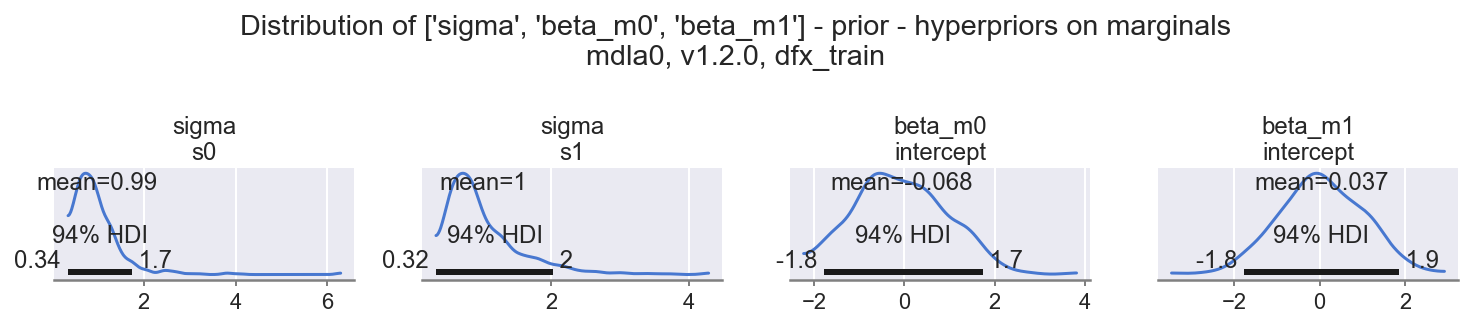

In [15]:
f = mt.facetplot_krushke(mdl=mdla0, group=GRP, txtadd='hyperpriors on marginals',
        rvs=mdla0.rvs_marg, m=4, rvs_hack=1)

**Observe:**

+ Priors contain the reference values, seems reasonable

#### ~~Evaluate priors on copula structure~~

No copula in this naive model

## 2.3 Sample Posterior, View Diagnostics

In [16]:
mdla0.sample(progressbar=True)
mdla0.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdla0.rvs_ppc + mdla0.rvs_det)
mdlio.write_idata(mdl=mdla0)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_copula/data/models/idata_mdla0_v120_dfx_train.netcdf')

In [17]:
mdla0.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> log_prior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[s0],0.421,0.043,0.343,0.499,0.001,0.001,3309.0,1712.0,1.01
sigma[s1],0.870,0.087,0.721,1.038,0.002,0.001,2804.0,1705.0,1.00
beta_m0[intercept],0.184,0.058,0.074,0.292,0.001,0.001,3036.0,1669.0,1.00
beta_m1[intercept],1.933,0.123,1.714,2.180,0.002,0.002,3060.0,1735.0,1.00


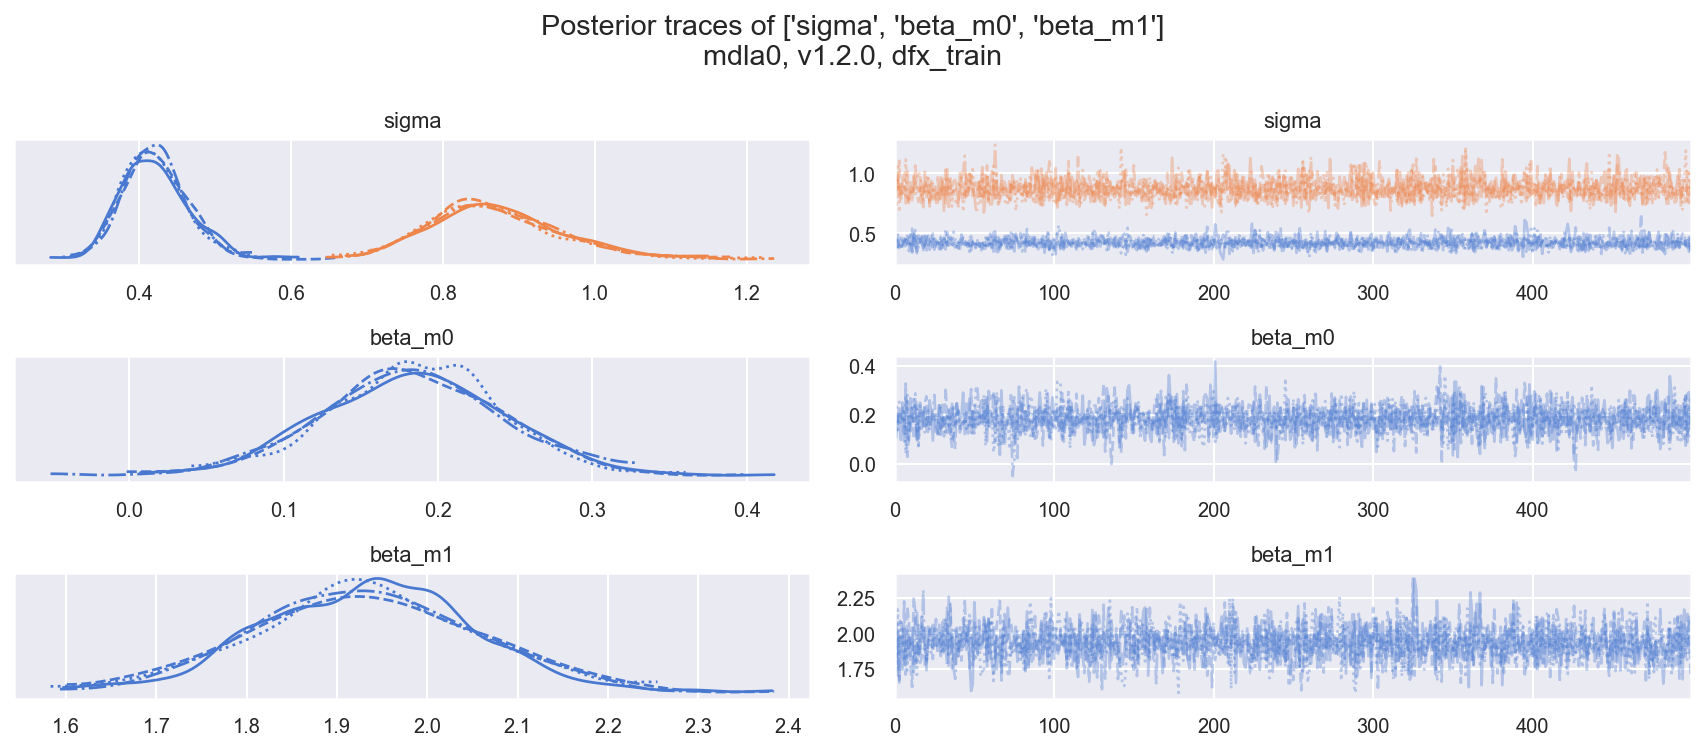

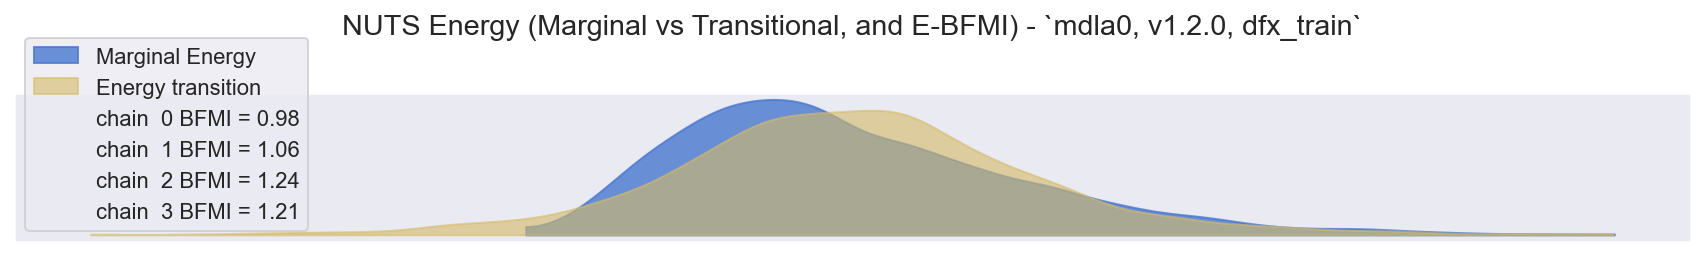

In [18]:
f = mt.plot_trace(mdl=mdla0, rvs=mdla0.rvs_marg, kind='trace')
f = mt.plot_energy(mdl=mdla0)
smry = mt.get_summary(mdl=mdla0, rvs=mdla0.rvs_marg)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 2.4 Evaluate Posterior PPC (In-Sample)

### 2.4.1 ECDF Plots: Univariate $M_{0}$, $M_{1}$

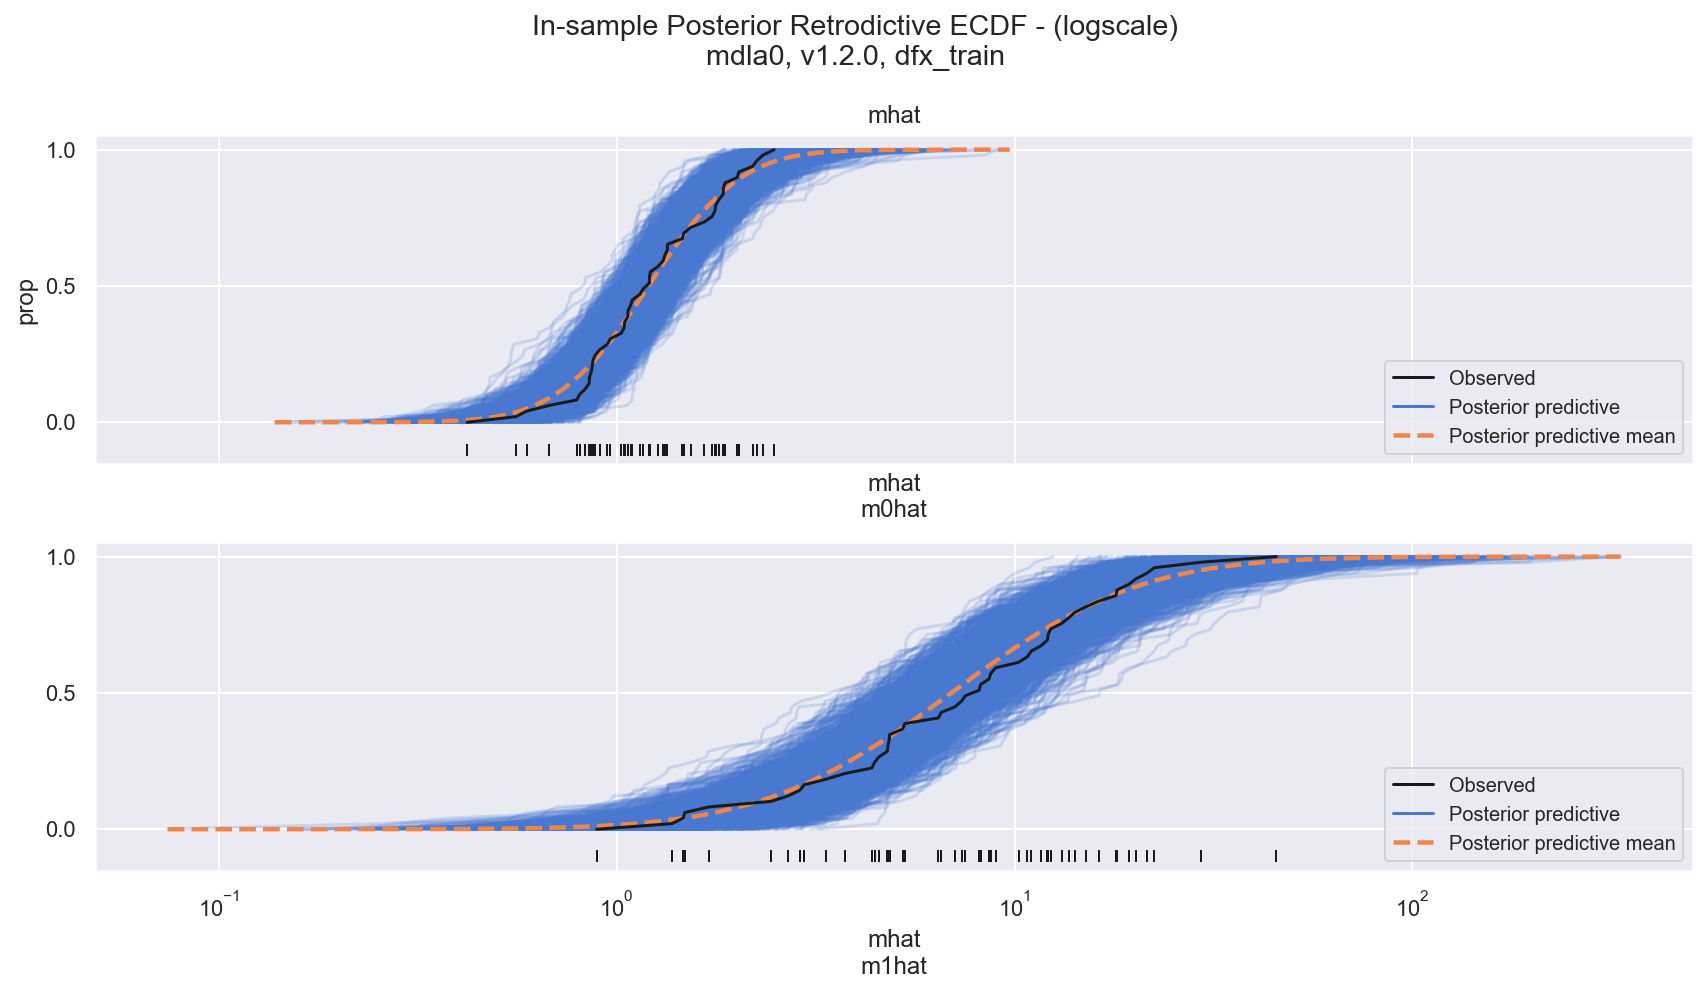

In [19]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=mdla0.rvs_ppc, insamp=True, logx=True, flatten=['oid'], observed_rug=True)

**Observe:**

+ `m0`: bulk has good fit, tails also good, but a little heavy
+ `m1`: bulk has good fit, tails okay but a little heavy

> Does this mean we have a good fit? We need to look at the covariance...

### 2.4.2 ECDF Plot: Resulting product $\hat{y}$

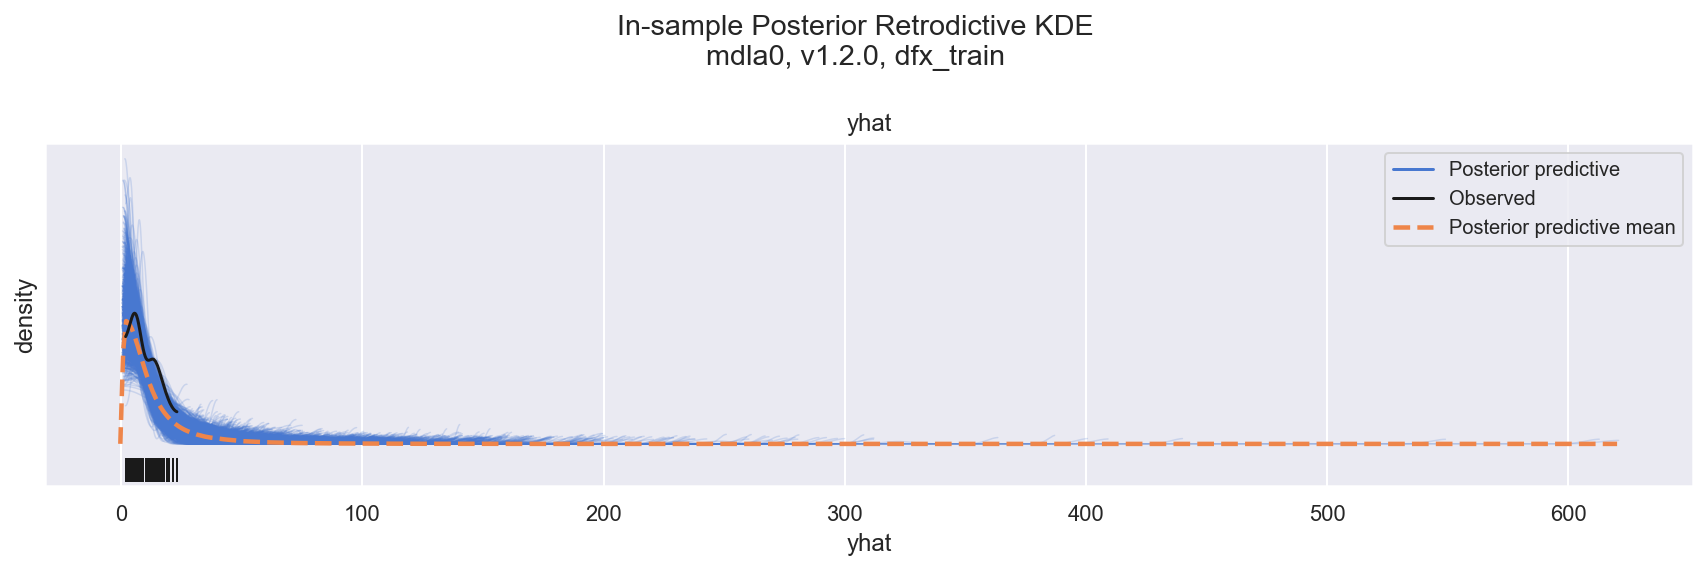

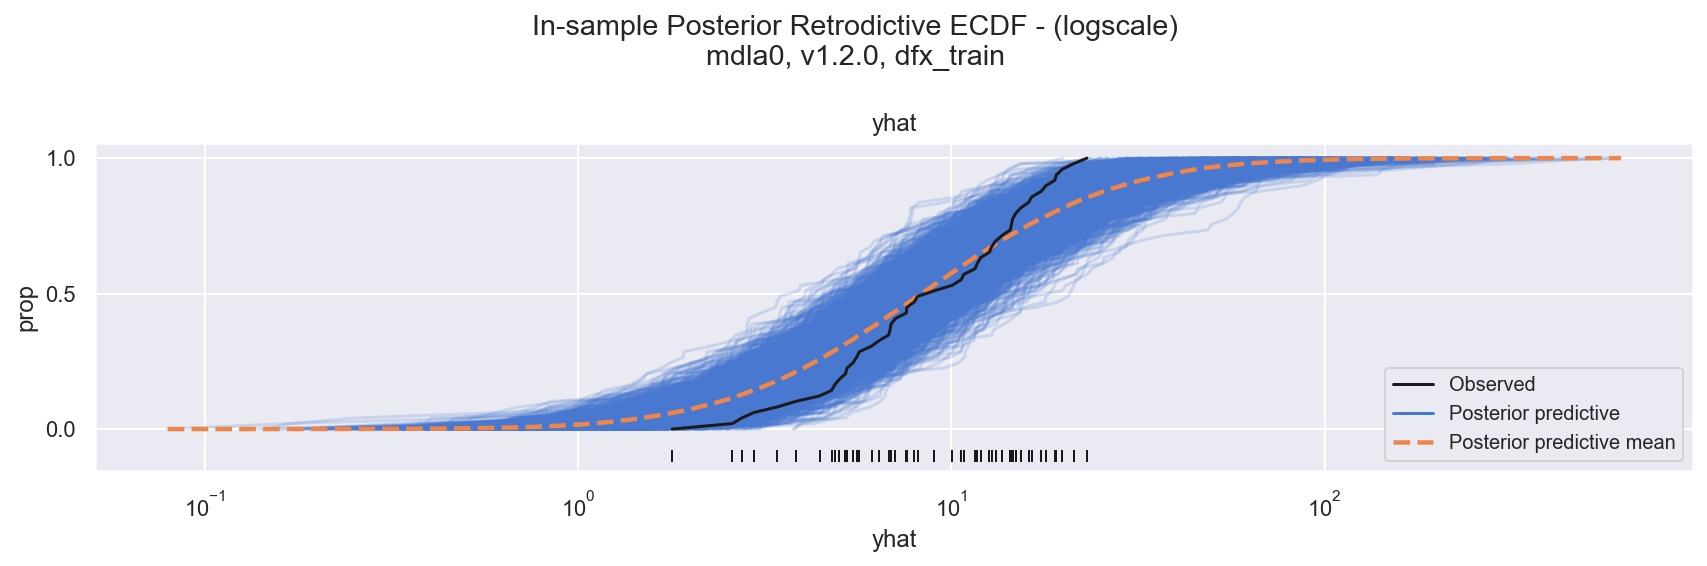

In [20]:
# post-process copy y into observed as yhat so we can work with it / plot it etc
mdla0.idata.observed_data = mdla0.idata.observed_data.assign(yhat=deepcopy(mdla0.idata.constant_data.y))
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=['yhat'], insamp=True, ecdf=False, observed_rug=True)
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=['yhat'], insamp=True, logx=True, observed_rug=True)

**Observe:**

+ This is a better measure of model fit accounting for covariance: the bulk is okay, but the tails are very overdispersed

### 2.4.3 Jointplots of PPC marginals - view the covariance

#### Mean

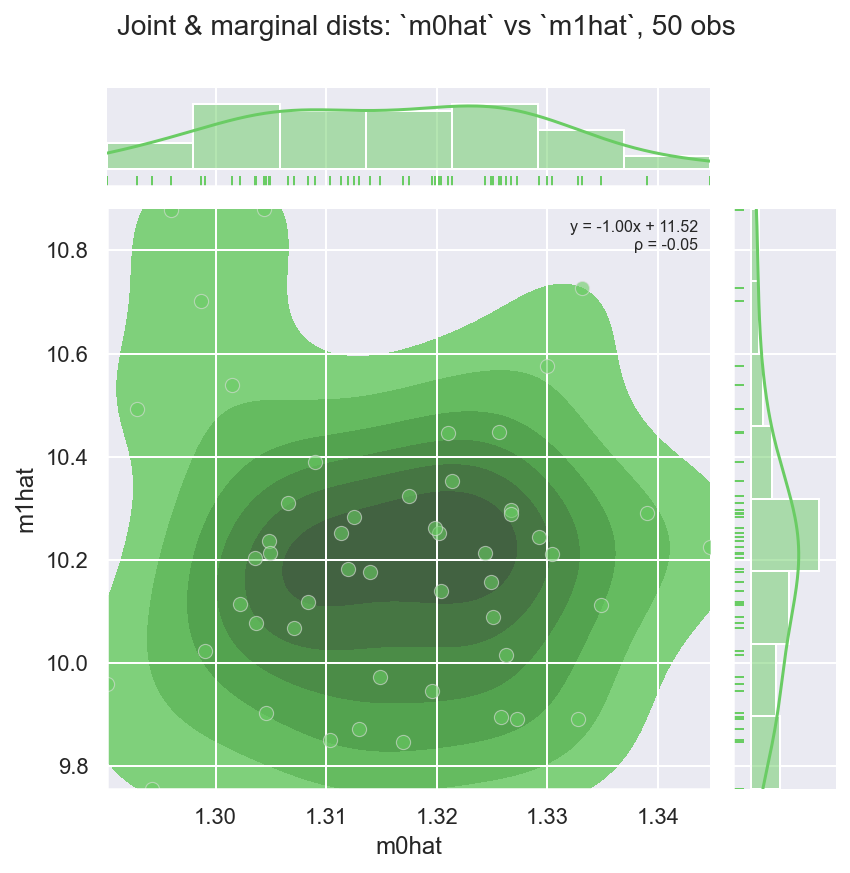

In [21]:
rv = 'mhat'
cols = mdla0.coords[f'{rv}_nm']
x = az.extract(mdla0.idata, group='posterior_predictive', var_names=rv).values
dfp_y = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            colori=2, subtitle='In-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Note the zero correlation $\rho \approx 0$, which doesn't map to our observed data

> This is a plot of the sample mean, so we might not expect to see tails here, instead we will look at the quantiles

#### Quantiles

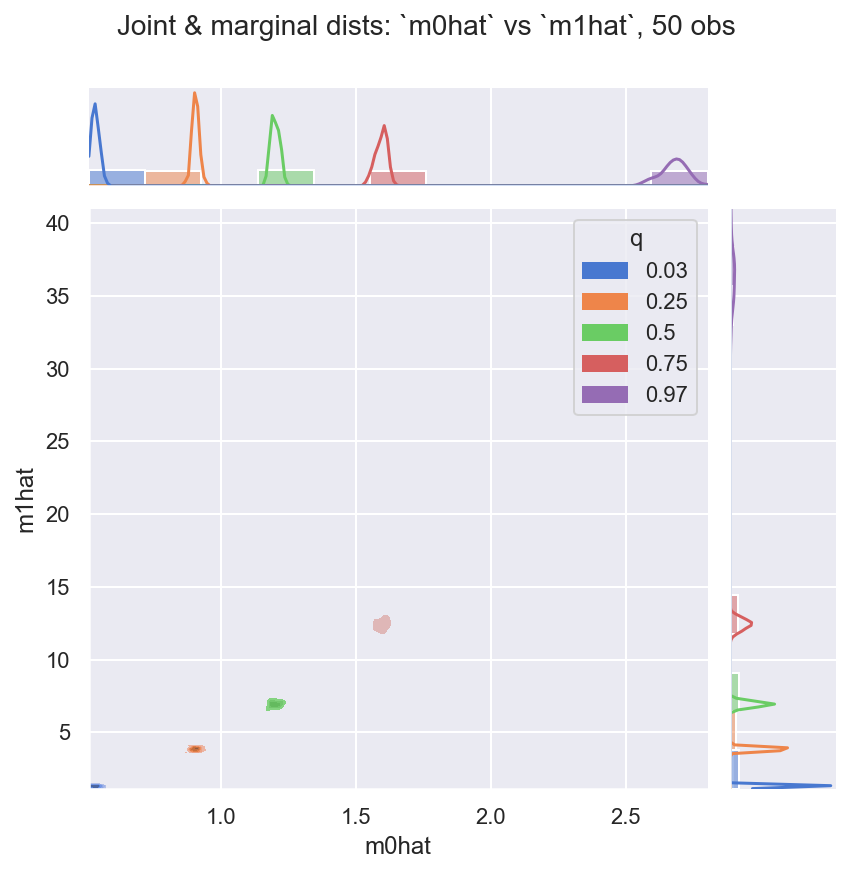

In [22]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdla0.n, 2), columns=cols)
dfp_q['q'] = np.repeat([f'{q}'  for q in qs], mdla0.n)
f = eda.plot_joint_numeric(data=dfp_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
            # legendpos='lower right',
            subtitle='In-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ The PPC quantile range covers the range of the observed data quite well, although within each quantile we still see the lack of covariance

> So the marginals fit well, but (as expected) the covariance in the data seems to not have been captured by the model

## 2.5 Evaluate LOO-PIT (In-Sample)

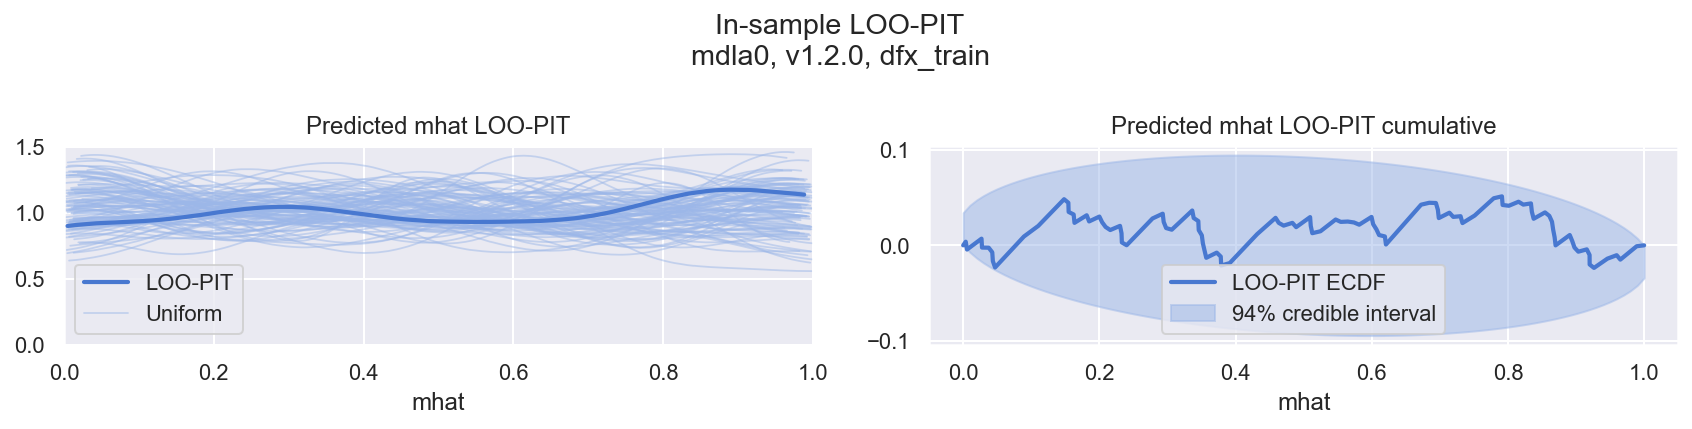

In [23]:
f = mt.plot_loo_pit(mdla0, data_pairs={'mhat': 'mhat'})

**Observe**

+ Seems like a good fit based on the marginals
+ Again we note this doesn't reflect the latent covariance structure in the observed data

## 2.6 ~~Compare Log-Likelihood vs other models~~

NOTE:

+ Nothing to compare with yet

## 2.7 Evaluate Fitted Posterior Parameters

NOTE: Because this is a synthetic dataset, we can evaluate parameter recovery

### 2.7.1 Univariate priors and hyperpriors on linear models

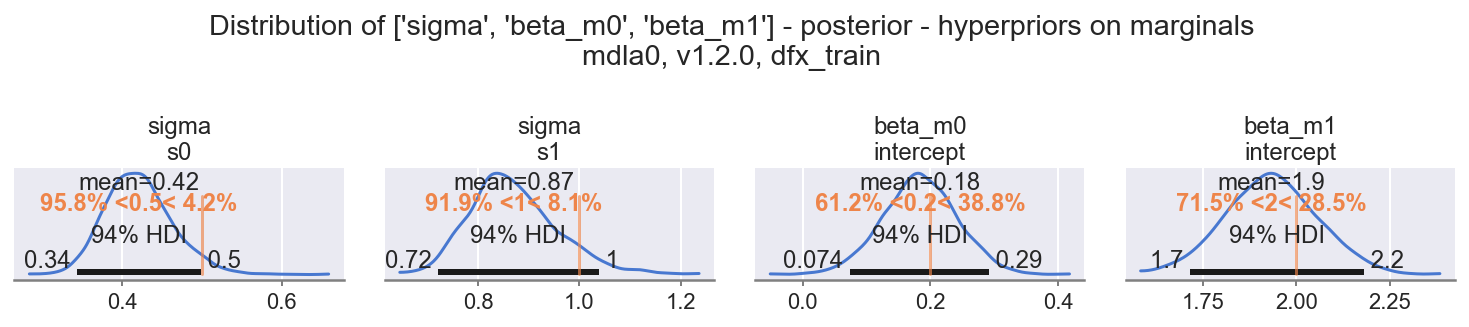

In [25]:
# get ref values from copula builder
refs = [cb.ref_vals['m0_params']['sigma'], cb.ref_vals['m1_params']['sigma'],
        cb.ref_vals['m0_params']['mu'], cb.ref_vals['m1_params']['mu']]
f = mt.facetplot_krushke(mdl=mdla0, group=GRP, txtadd='hyperpriors on marginals',
        rvs=mdla0.rvs_marg, ref_vals=refs, m=4, rvs_hack=1)

**Observe:**

+ `sigma: S0`: $\mathbb{E} \approx 0.46$: a little lower and narrower than prior. $\text{HDI}_{94} \ni \text{refval}$
+ `sigma: S1`: $\mathbb{E} \approx 1.0$: narrower than prior, but same location. $\text{HDI}_{94} \ni \text{refval}$
+ `beta_m0: intercept`: $\mathbb{E} \approx 0.2, \text{HDI}_{94} \not\ni 0$: slightly positive, substantial effect. $\text{HDI}_{94} \ni \text{refval}$
+ `beta_m1: intercept`: $\mathbb{E} \approx 2.0, \text{HDI}_{94} \not\ni 0$: more positive, substantial effect. $\text{HDI}_{94} \ni \text{refval}$.
+ Parameter recovery looks good for all.

### 2.7.2 Bivariate hyperpriors - looking for correlations

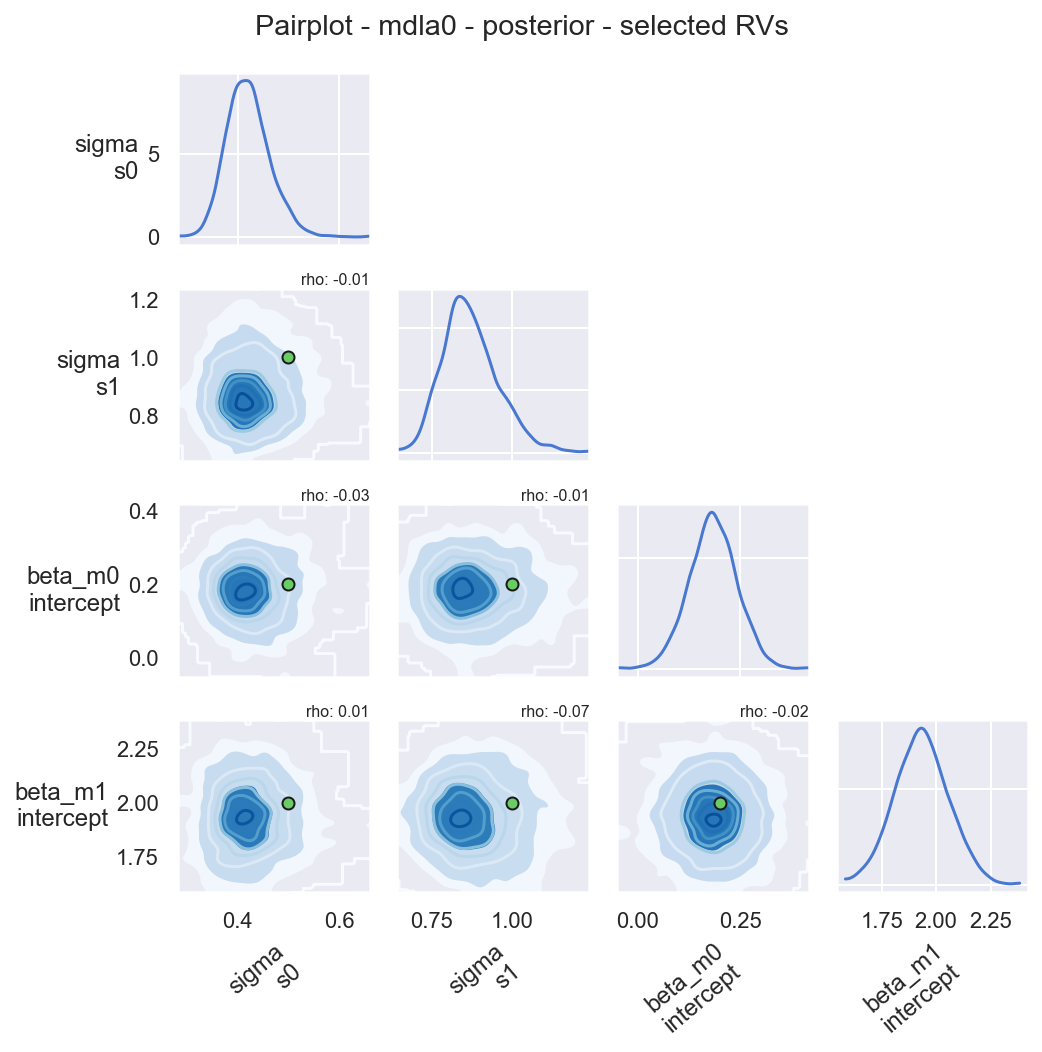

In [26]:
refsd = {'sigma\ns0': cb.ref_vals['m0_params']['sigma'], 
        'sigma\ns1' :cb.ref_vals['m1_params']['sigma'],
        'beta_m0\nintercept': cb.ref_vals['m0_params']['mu'], 
        'beta_m1\nintercept': cb.ref_vals['m1_params']['mu']}
f = mt.pairplot_corr(mdl=mdla0, rvs=mdla0.rvs_marg, ref_vals=refsd)

**Observe:**

+ Another view of the parameter recovery for marginal linea submodel parameters - which seems good for all.
+ Note lack of correlation between `beta_m0` and `beta_m1` because they're not
  correlated in the model

### ~~2.7.3 Copula Structure~~

In [27]:
# Placeholder unused

---

---

In [28]:
assert False, "WIP"

AssertionError: WIP

## 2.8 Forecast Marginals $\hat{M_{0}}$, $\hat{M_{1}}$ on Out-of-Sample Holdout Set

**Discussion**

 
Strictly speaking, our Bayesian modeling workflow does not require us to evaluate the model on an **out-of-sample** 
Holdout (aka Test) sub-dataset because we use in-sample Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing 
shown above. This is more powerful and lets us fit & evaluate the model using the full Working set. 

However, because this model is parametric, we _can_ **forecast** marginals $\hat{M_{0}}$, $\hat{M_{1}}$ for observations
in an **out-of-sample dataset**:
+ In the real-world, all we really care about is model inference (shown above) and predicting 
  $\hat{M_{0}}$, $\hat{M_{1}}$ for actual real observed new datapoints
+ For the purpose of greater explanation, in this Notebook we demonstrate prediction on an out-of-sample dataset
+ Specifically we use the `holdout` dataset defined above, where we know the true value and can directly compare to the prediction

In [ ]:
## 2.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

---

---

# 5. Predict Out-of-Sample (Holdout Set)

## 5.1 Sample PPC holdout

In [ ]:
# # replace obs with dfx_pholdout and build
# mdl.replace_obs({'obs_m0': dfx_m0_holdout, 'obs_m1':dfx_m1_holdout})
# mdl.build()

In [ ]:
# fqn = trainer.mdlio.write_graph(mdl, txtadd='holdout')  # output model graph to prove rebuilt
# f = eda.display_image_file(fqn, 
#     title=f'Rebuilt model architecture for holdout: {mdl.name} {mdl.version}', figsize=(12, 6))

In [ ]:
# idata_holdout = mdl.sample_posterior_predictive(store_ppc=False, 
#         ppc_insample=True,  # hack to ensure output is named posterior_predictive so we can do EDCF
#         var_names=mdl.rvs_ppc)

# GROUP = 'posterior_predictive'  # predictions

# idata_holdout

## 5.2 Plot holdouts

Calling back to **1.2.6 Compare the Impact on Joint Distribution** we might consider the PPC Joint Distribution here too. We will keep with the theme that this might represent a Expected Loss Cost $E_{loss}$

NOTE:

+ Within each marginal, the samples for the posterior parameters of a submodel 
  are coherent across the joint posterior parameter space
+ This means for example, that within parameters `yhat0` etc, each of 
  samples `0, 1, 2, 3 ... j` gives us the full state of the model at that point 
  in the Markov chain
+ So, we use all parameter values at each sample `0, 1, 2, 3 ... j`, to get 
  `j` estimates of the posterior parameter values, and thus the predictions
+ We usually set `j = 2000`, so we have $2000$ predictions for each observation

In [ ]:
# yhat = az.extract(idata_holdout, group=GROUP, var_names=mdl.rvs_ppc).values
# yhat_eloss = np.product(yhat, axis=1)
# yhat_eloss.shape

### 5.2.1 Plot holdout Full Set Distribution

In [ ]:
# df_yhat_eloss = pd.DataFrame(yhat_eloss, index=dfx_m0_holdout.index)
# dfm_yhat_eloss = df_yhat_eloss.reset_index().melt(
#                         id_vars='index', value_name='yhat', var_name='sample')
# eda.display_ht(df_yhat_eloss)

In [ ]:
# f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat')

In [ ]:
# f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat', kind='exceedance')

**Observe:**

+ Quite a long tail, high mean, doesn't seem unreasonable

### 5.2.2 Plot holdout Individual Observations

In [ ]:
# mn_pt_kws=dict(markerfacecolor='w', markeredgecolor='#333333', marker='d', markersize=8)
# box_kws=dict(kind='box', sym='', orient='h', showmeans=True, whis=(3, 97), meanprops=mn_pt_kws)
# nobs = len(df_yhat_eloss)
# gd = sns.catplot(x='yhat', y='index', data=dfm_yhat_eloss, **box_kws, height=4, aspect=2)
# _ = gd.fig.suptitle(f'Individual Distribution of yhat Estimate for {nobs} Observations')
# _ = gd.fig.tight_layout()

#### 5.2.3 Mean Joint Distribution

In [ ]:
# rv = 'yhat'
# cols = mdl.coords[f'{rv}_nm']
# x = az.extract(idata_holdout, group=GROUP, var_names=rv).values
# dfp_y = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
# f = eda.plot_joint_numeric(data=dfp_y, ft0=cols[0], ft1=cols[1], kind='kde+scatter', colori=2, 
#             subtitle='holdout Out-of-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Quite broad variance
+ But marginals and joint look reasonably close to holdout actual values

#### 5.2.4 Quantile Joint Distribution

In [ ]:
# qs = [0.03, 0.25, 0.5, 0.75, 0.97]
# dfp_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdl.n, 2), columns=cols)
# dfp_q['q'] = np.repeat([f'{q}'  for q in qs], mdl.n)
# f = eda.plot_joint_numeric(data=dfp_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
#             legendpos='lower right',
#             subtitle='holdout Out-of-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ Very interesting! The PPC quantile range looks reasonable

**In the real world, we have to stop here, because in a holdout scenario we dont have `y`**

---

# 6. Evaluate Predictions (Holdout Set)

**IMPORTANT NOTE** 

Strictly speaking, in a **holdout** dataset / scenario we dont have `y`, but in
this worked example Notebook we do have `y`, so we can treat this more like a 
**Holdout** dataset / scenario, and add several evaluations including:

+ Plot Summarised Predictions with overplotted Actual
+ Plot PPC ECDF
+ Plot Coverage / Calibration
+ Plot RMSE and R^2


## 6.1 Evaluate holdout Joint Distribution ($E_{loss}$)

### 6.1.1 Plot Summarised Predictions with overplotted Actual

In [ ]:
# y_m0 = dfx_m0_holdout['m0'].values
# y_m1 = dfx_m1_holdout['m1'].values
# y_eloss = y_m0 * y_m1
# df_y_eloss = pd.DataFrame({'y': y_eloss}, index=dfx_m0_holdout.index).reset_index()

In [ ]:
# f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat', 
#                     arroverplot=df_y_eloss['y'], txtadd='with overplotted bootstrapped Actual')
# figio.write(f, fn=f'100_6.1.1_holdout_prediction_{mdl.name}')

**Observe:**

+ Now we can see the prediction from this naive model is much too high and the 
  variance is too large
+ The overplotted actual sample mean is 9.3, and the estimated mean is 16.2,
  a $16.2/9.3 \sim +74\%$ overestimate!


### 6.1.2 Plot PPC EDCF

In [ ]:
# # hacky correct for sample_posterior_predictive not creating observed data 
# # (because model observed_RVs is empty)
# if 'observed_data' not in idata_holdout.groups():
#     idata_holdout.add_groups(observed_data=deepcopy(mdl.idata.observed_data))

# idata_holdout

In [ ]:
# _ = mt.plot_ppc(mdl, idata=idata_holdout, group='posterior', insamp=False,
#                 data_pairs={'yhat': 'yhat'}, flatten=['oid'], observed_rug=True)

**Observe:**

+ Bulk: reasonably good fits, but high variance
+ Tails: reasonable fit, rather heavier than observed, esp for `yhat1`

### 6.1.3 Plot Coverage

In [ ]:
# df_cov_eloss = mt.calc_ppc_coverage(y_eloss, yhat_eloss.T)
# f = eda.plot_coverage(df_cov_eloss)

**Observe:**

+ Reasonably well-calibrated
+ AUC: quite large

### 6.1.4: Plot RMSE and R^2

In [ ]:
# rmse, rmse_pct = mt.calc_rmse(y_eloss, yhat_eloss.T)
# f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='yhat_eloss')

# r2 = mt.calc_bayesian_r2(y_eloss, yhat_eloss)
# f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE quite high variance
+ R^2 mean seems reasonable, but has high variance

## 6.2 Evaluate Marginal Distributions

**IMPORTANT NOTE** 

Strictly speaking, in a **holdout** dataset / scenario we dont have `y`, but in
this worked example Notebook we do have `y`, so we can treat this more like a 
**Holdout** dataset / scenario, and add several evaluations including:

+ Plot Coverage
+ Plot RMSE and R^2


### 6.2.1 Margin M0

#### 6.2.1.1 Coverage

In [ ]:
# dfcov_m0 = mt.calc_ppc_coverage(y_m0, yhat[:, 0].T)
# f = eda.plot_coverage(dfcov_m0)

**Observe:**

+ Looks pretty well-calibrated

#### 6.2.1.2: RMSE and R^2

In [ ]:
# rmse, rmse_pct = mt.calc_rmse(y_m0, yhat[:, 0].T)
# f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='m0')

# r2 = mt.calc_bayesian_r2(y_m0, yhat[:, 0])
# f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE quite high variance
+ R^2 mean seems reasonable, but has high variance

### 6.2.2 Margin M1

#### 6.2.2.1 Coverage

In [ ]:
# dfcov_m1 = mt.calc_ppc_coverage(y_m1, yhat[:, 1].T)
# f = eda.plot_coverage(dfcov_m1)

**Observe:**

+ Also reasonably well-calibrated

#### 6.2.2.2: RMSE and R^2

In [ ]:
# rmse, rmse_pct = mt.calc_rmse(y_m1, yhat[:, 1].T)
# f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='m1')

# r2 = mt.calc_bayesian_r2(y_m1, yhat[:, 1])
# f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE quite high variance
+ R^2 mean seems reasonable, but has high variance

---

---

# Notes

In [ ]:
# Sanity-check Lognorm Implementations `scipy` vs `pymc`
mt.sanity_check_lognorm(cb.ref_vals['m0_params']['mu'], cb.ref_vals['m1_params']['sigma'])

In [ ]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

---
**Oreum OÜ &copy; 2024**